### Habr (Article Popularity Prediction)
Predict the popularity of a post on Habr based on the content and time of publication. As you know, Habr users can add articles to their favorites. The total number of users who did this is displayed by the number of stars on the article. We will assume that the number of stars given to an article best reflects its popularity.

- [Competition Link](https://www.kaggle.com/c/howpop-habrahabr-favs/overview)
- [Train](https://disk.yandex.ru/d/hAhCuetI3JPouk)/[Test](https://disk.yandex.ru/d/mLMZZtN63JPouc) datasets for the competition

In [37]:
import re
import pandas as pd
import numpy as np
import warnings
import pymorphy2
import matplotlib.pyplot as plt

from typing import Dict, List
from collections import defaultdict

from nltk.corpus import stopwords
from gensim.models import word2vec

from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge

warnings.filterwarnings('ignore')

### Data Downloading

In [2]:
train_df = pd.read_csv('/home/jovyan/work/data_sets/habr_article_pop_pred/train_content.csv')
test_df = pd.read_csv('/home/jovyan/work/data_sets/habr_article_pop_pred/test_content.csv')

print('Train Shape: ', train_df.shape)
print('Test Shape: ', test_df.shape)

train_df.head()

Train Shape:  (172913, 13)
Test Shape:  (5405, 12)


,_id,date,tags,title,hubs_title,description,name,hub,png,nick,url,content,favs_lognorm
0,https://geektimes.ru/post/21866/,2008-03-17T18:55:00.000Z,"['eeepc', 'asus', 'ЭТО', 'эльдорадо', 'ура']",eeePC в продаже. Да. Правда.,Железо,"Итак, если 3 дня назад я отписался то что в пр...",Сергей 'pokatusher',hub/hardware,https://habrastorage.org/getpro/habr/olpicture...,@M_org,https://geektimes.ru/users/M_org,"Итак, если 3 дня назад я <a href=""http://habra...",2.484907
1,https://habrahabr.ru/company/aladdinrd/blog/30...,2016-06-24T13:02:00.000Z,"['Интеграция', 'шифрование', 'Windows', 'Win32...",«Разрубить Гордиев узел» или преодоление пробл...,Системное программирование,Современная операционная система это сложный и...,Аладдин Р.Д.,hub/system_programming,https://habrastorage.org/files/cbd/cf9/5ff/cbd...,NaN,https://habrahabr.ru/company/aladdinrd,Современная операционная система это сложный и...,4.174387
2,https://geektimes.ru/post/92887/,2010-05-06T10:00:00.000Z,"['mc', 'midnight commander', 'diffview', 'merg...",Релиз Midnight Commander 4.7.2 и 4.7.0.5,Чёрная дыра,Спустя 2 месяца упорных трудов вышла новая вер...,Илья Маслаков,hub/closet,https://geektimes.ru/images/logo.png,@smind,https://geektimes.ru/users/smind,Спустя 2 месяца упорных трудов вышла новая вер...,0.000000
3,https://habrahabr.ru/post/290824/,2015-05-22T11:01:00.000Z,"['бизнес-модель', 'бизнес-моделирование']",7 шагов для постройки правильной бизнес-модели,Интернет-маркетинг,Большинство IT предпринимателей сосредотачиваю...,Александр,hub/internetmarketing,https://habrastorage.org/files/50e/211/9a0/50e...,@jasiejames,https://habrahabr.ru/users/jasiejames,"<img src=""https://habrastorage.org/files/50e/2...",3.496508
4,https://habrahabr.ru/post/190088/,2014-09-04T00:32:00.000Z,"['python', 'flask', 'mongodb', 'pet-project']",Thunderargs: практика использования. Часть 2,Программирование,История создания Часть 1 Добрый день. Вкратце...,Данияр Супиев,hub/programming,https://habrahabr.ru/i/habralogo.jpg,@uthunderbird,https://habrahabr.ru/users/uthunderbird,"<a href=""http://habrahabr.ru/post/223041/"">Ист...",3.688879


### Data Preprocessing
First of all let's preprocess the texx (lowercase, stopwords removal, lemmatization, ...). Since all articles are written in Russian, we need to use some tools, one of them is `Pymorphy2`.

Pymorphy2 is a Python library for morphological analysis and inflection of Russian words. It allows you to perform tasks such as determining the grammatical attributes of words (e.g., their part of speech, gender, number, case), generating word forms, and lemmatizing words. 

In [3]:
morph_analyzer = pymorphy2.MorphAnalyzer()

# in articles may appear English words
stop_words = set(stopwords.words("english")).union(set(stopwords.words("russian")))

def preprocess_text(text):
    text = re.sub("[^а-яА-Яa-zA-Z]"," ", text)
    words = text.lower().split()
    words = [w for w in words if not w in stop_words]
    # TODO: some articles have HTML tags that must be removed as well (potential)
    words = [morph_analyzer.parse(w)[0].normal_form for w in words]
    return words

In [4]:
%%time

# date and time preprocessing
train_df['date'] = train_df['date'].apply(pd.to_datetime)
train_df['year'] = train_df['date'].apply(lambda x: x.year)
train_df['month'] = train_df['date'].apply(lambda x: x.month)

test_df['date'] = test_df['date'].apply(pd.to_datetime)
test_df['year'] = test_df['date'].apply(lambda x: x.year)
test_df['month'] = test_df['date'].apply(lambda x: x.month)

print(f"Time frame (Train): {train_df['date'].min().date()} | {train_df['date'].max().date()}")
print(f"Time frame (Test): {test_df['date'].min().date()} | {test_df['date'].max().date()}")

Time frame (Train): 2006-01-16 | 2016-12-31
Time frame (Test): 2017-01-01 | 2017-04-26
CPU times: user 13.2 s, sys: 89.7 ms, total: 13.3 s
Wall time: 13.3 s


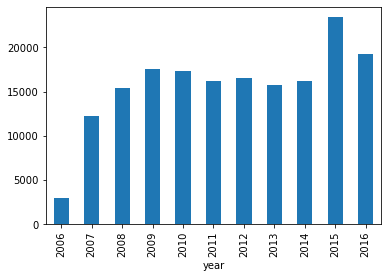

In [5]:
# look at articles distribution per year
articles_dist = train_df.groupby('year')['_id'].nunique()
articles_dist.plot(kind='bar')
plt.show()

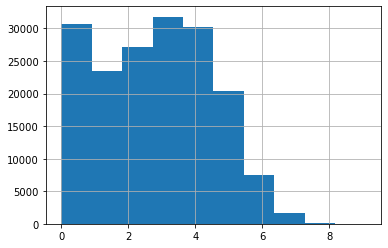

In [75]:
# target distribution
train_df['favs_lognorm'].hist()
plt.show()

### Train/Test Split
- Training data: articles **from 2015**
- Validation data: first 4 months of 2016
- Other options are possible as well

In [66]:
X_train = train_df[train_df['year'] == 2015]
X_val = train_df[
    (train_df['year'] == 2016) & (train_df['month'] <= 4)
]

y_train = X_train['favs_lognorm']
y_val = X_val['favs_lognorm']

X_train = X_train.drop('favs_lognorm', axis=1)
X_val = X_val.drop('favs_lognorm', axis=1)

### Embeddings Learning / Word2Vec
Train word2vec model to get embeddings and train a model on them

In [69]:
text_data = pd.concat([X_train, X_val], axis=0, ignore_index=True)
labels = pd.concat([y_train, y_val], axis=0, ignore_index=True)
text_data.head()

,_id,date,tags,title,hubs_title,description,name,hub,png,nick,url,content,year,month
0,https://habrahabr.ru/post/290824/,2015-05-22 11:01:00+00:00,"['бизнес-модель', 'бизнес-моделирование']",7 шагов для постройки правильной бизнес-модели,Интернет-маркетинг,Большинство IT предпринимателей сосредотачиваю...,Александр,hub/internetmarketing,https://habrastorage.org/files/50e/211/9a0/50e...,@jasiejames,https://habrahabr.ru/users/jasiejames,"<img src=""https://habrastorage.org/files/50e/2...",2015,5
1,https://geektimes.ru/post/246882/,2015-03-06 16:40:00+00:00,"['dawn', 'ceres', 'церера']",Зонд Dawn вышел на орбиту Цереры,Космонавтика,фото: НАСА Сегодня зонд Dawn завершил своё по...,Вячеслав Голованов,hub/space,https://habrastorage.org/getpro/geektimes/post...,@SLY_G,https://geektimes.ru/users/SLY_G,"<img src=""https://habrastorage.org/getpro/geek...",2015,3
2,https://habrahabr.ru/post/264585/,2015-08-12 12:00:00+00:00,"['си', 'начинающим']","Будь проще, и люди потянутся к тебе, или как п...",Совершенный код,Я по жизни самоучка: если не считать FORTRAN и...,NaN,hub/complete_code,https://habrastorage.org/getpro/habr/post_imag...,@sim-dev,https://habrahabr.ru/users/sim-dev,"<img src=""https://habrastorage.org/getpro/habr...",2015,8
3,https://habrahabr.ru/company/audiomania/blog/2...,2015-02-03 12:58:00+00:00,"['электронная коммерция', 'amazon']",Что общего у eCommerce и медведя гризли?,Блог компании Аудиомания,За два десятилетия развития электронной коммер...,NaN,company/audiomania,https://habrastorage.org/files/a71/0fd/51d/a71...,NaN,https://habrahabr.ru/company/audiomania/blog/2...,"<a href=""http://megamozg.ru//company/audiomani...",2015,2
4,https://habrahabr.ru/post/269955/,2015-11-02 10:28:00+00:00,"['scala', 'functional programming', 'problems']",Простые Задачи и Функционально-Блондинистый По...,Функциональное программирование,Пару месяцев назад я взяла на себя обязательст...,Мария,hub/funcprog,https://habrastorage.org/files/4e9/8c7/9db/4e9...,@Musia17,https://habrahabr.ru/users/Musia17,"<img src=""https://habrastorage.org/files/4e9/8...",2015,11


In [44]:
%%time

# Nan -> 'str'
text_data['content_clear'] = text_data['content'].apply(str)

# preprocess
text_data['content_clear'] = text_data['content_clear'].apply(preprocess_text)

CPU times: user 1h 17min 39s, sys: 3.14 s, total: 1h 17min 42s
Wall time: 1h 17min 42s


**Important**
- Preprocessing on such big dataset consumes much RAM -> we **save the clean text after preprocessing and download again**
- Better use pickle format

In [60]:
# save ask pkl to release the resources
text_data['content_clear'].to_pickle('preprocessed_text.pkl')

To rellease the resources:
- Restart the kernel
- del df and use garbage collector

In [61]:
# release resources
import gc

del text_data['content_clear']
gc.collect()

In [9]:
# read preprocessed text -> tokens to train word2vec
clean_text = pd.read_pickle('preprocessed_text.pkl')

In [14]:
%%time

# define word2vec model
w2v_model = word2vec.Word2Vec(clean_text, vector_size=300, window=3, workers=4)

# define vocab and embeddigs
embeddings_vocab = dict(zip(w2v_model.wv.index_to_key, w2v_model.wv.vectors))
print('Model Vocab Size: ', len(embeddings_vocab.keys()))

CPU times: user 7min 35s, sys: 3.07 s, total: 7min 38s
Wall time: 2min 10s


**Test Trained Word2Vec Model**

In [25]:
w2v_model.wv.most_similar(positive=['open', 'data','science','best'])

[('scientists', 0.6540507674217224),
 ('massive', 0.6530531644821167),
 ('breach', 0.6388026475906372),
 ('knowledge', 0.636269211769104),
 ('analyst', 0.6330214738845825),
 ('teams', 0.6267001628875732),
 ('visualization', 0.625065267086029),
 ('visualizing', 0.6241403222084045),
 ('mining', 0.6225045323371887),
 ('storing', 0.6192912459373474)]

- similar words make sense -> model was trained well

**Mean Embeddings of Documents**
- Apply IDF mean for tokens to get better document embeddings

In [21]:
class CustomTfIdfVectorizer():
    def __init__(self, embeddings_vocab: Dict[str, np.ndarray]) -> None:
        self.embeddings_vocab = embeddings_vocab
        self.dim = len(next(iter(self.embeddings_vocab.values())))
        self.weight = None


    def fit(self, X: List[str]) -> None:
        """
        Computes IDF weights for tokens.
        
        Important
        ---------
        Words that are missed in vocab must be as infrequent as any known words.
        Thus, the default IDF value for them is max(idf).

        Parameters
        ----------
        X: list
            Sentence (i.e. sequence of tokens).
        """
        # fit TfidfVectorizer
        tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x: x)
        tfidf_vectorizer.fit(X)

        max_idf = max(tfidf_vectorizer.idf_) # this weight will have words that are missing in vocab

        self.weight = defaultdict(
            lambda: max_idf,
            [
                (w, tfidf_vectorizer.idf_[i]) for w, i in tfidf_vectorizer.vocabulary_.items()
            ]
        )
        return None

    def transform(self, X: List[str]) -> np.ndarray:
        """Returns IDF weighted mean embedding vector of a sentence."""
        return np.array([
            np.mean(
                [self.embeddings_vocab[w] * self.weight[w] for w in words if w in self.embeddings_vocab] 
                or
                [np.zeros(self.dim)], axis=0 # if word is missing, it has zero vector and max(idf)
            )
            for words in X
        ])

In [30]:
%%time

idf_vectorizer = CustomTfIdfVectorizer(embeddings_vocab)
idf_vectorizer.fit(clean_text)

# get idf mean embeddings for documents
idf_mean_embeddings = idf_vectorizer.transform(clean_text)

In [70]:
def get_train_val_data(X, y, ratio):
    idx = ratio
    return X[:idx, :], X[idx:, :], y[:idx], y[idx:]

X_train, X_val, y_train, y_val = get_train_val_data(
    idf_mean_embeddings, y=labels, ratio=23425
)

### Model Training
**Linear Models**

In [73]:
ridge_model = Ridge(alpha=1, random_state=23)
ridge_model.fit(X_train, y_train)

train_preds = ridge_model.predict(X_train)
val_preds = ridge_model.predict(X_val)

mse_train = mean_squared_error(y_train, train_preds)
mse_val = mean_squared_error(y_val, val_preds)
y_median = np.ones(len(val_preds))*y_train.median()

print('Train Error: ', mse_train)
print('Validation Error: ', mse_val)
print('Validation Error (Median Prediction): ', y_median)

Train Error:  0.7630896213765483
Validation Error:  0.698094783319037
Validation Error (Median Prediction):  [3.36729583 3.36729583 3.36729583 ... 3.36729583 3.36729583 3.36729583]


**Neural Net**

In [76]:
from keras import regularizers
from keras.layers import Activation, Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasRegressor

In [79]:
def baseline_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(
    build_fn=baseline_model,
    epochs=20, nb_epoch=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=2
)

In [80]:
estimator.fit(X_train, y_train)

2024-04-13 20:48:41.240534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
367/367 - 1s - loss: 1.7729 - val_loss: 0.7650
Epoch 2/20
367/367 - 1s - loss: 1.2404 - val_loss: 0.6848
Epoch 3/20
367/367 - 1s - loss: 1.1565 - val_loss: 0.7024
Epoch 4/20
367/367 - 1s - loss: 1.0929 - val_loss: 0.7610
Epoch 5/20
367/367 - 1s - loss: 1.0663 - val_loss: 0.6722
Epoch 6/20
367/367 - 1s - loss: 1.0120 - val_loss: 0.6737
Epoch 7/20
367/367 - 1s - loss: 0.9862 - val_loss: 0.6326
Epoch 8/20
367/367 - 1s - loss: 0.9534 - val_loss: 0.6820
Epoch 9/20
367/367 - 1s - loss: 0.9185 - val_loss: 0.6269
Epoch 10/20
367/367 - 1s - loss: 0.8981 - val_loss: 0.6421
Epoch 11/20
367/367 - 1s - loss: 0.8919 - val_loss: 0.7912
Epoch 12/20
367/367 - 1s - loss: 0.8635 - val_loss: 0.6467
Epoch 13/20
367/367 - 1s - loss: 0.8227 - val_loss: 0.6639
Epoch 14/20
367/367 - 1s - loss: 0.8079 - val_loss: 0.6964
Epoch 15/20
367/367 - 1s - loss: 0.8060 - val_loss: 0.6174
Epoch 16/20
367/367 - 1s - loss: 0.7987 - val_loss: 0.6128
Epoch 17/20
367/367 - 1s - loss: 0.7764 - val_loss: 0.6038
Epoch 

In [81]:
train_preds = estimator.predict(X_train)
val_preds = estimator.predict(X_val)

mse_train = mean_squared_error(y_train, train_preds)
mse_val = mean_squared_error(y_val, val_preds)
y_median = np.ones(len(val_preds))*y_train.median()

print('Train Error: ', mse_train)
print('Validation Error: ', mse_val)
print('Validation Error (Median Prediction): ', y_median)

367/367 - 0s
119/119 - 0s
Train Error:  0.6547060014248149
Validation Error:  0.6108538912317751
Validation Error (Median Prediction):  [3.36729583 3.36729583 3.36729583 ... 3.36729583 3.36729583 3.36729583]


**Results Analysis**
- NN provided much better results than Ridge Regression
- All the models in the notebook are baseline models

### Leaderboard Performance
Let's check how well we trained our model.
- [Competition Leaderboard](https://www.kaggle.com/c/howpop-habrahabr-favs/leaderboard)

In [ ]:
# preprocess test data -> clean test

In [ ]:
# idf mean for clean test

In [ ]:
# predict 

### Further Potential
We trained a model only on embeddings that allowed drastically reducing dimensionality. However, we have only embedding features and other features can be created as well. For example:
- Time related features:
    - Month, day, time of day, ...
    - Posting Time
    
- Author features
    - N posts 
    - Average rating
    - ...

- Content Related Features
    - Pictures in article
    - How many pictures
    - ...